<a href="https://colab.research.google.com/github/JayV1I/Aulas-pucc/blob/main/TRABALHO_2_BIGDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql.functions import round

In [38]:
spark = SparkSession.builder.appName("TRABALHO_PI_PCA").getOrCreate()

In [39]:
data = '/content/cod.csv'

In [40]:
df = spark.read.csv(data, header=True, inferSchema=True)

In [41]:
df.show()

+--------------------+----+-----+------------------+----------+-----+------+--------+-----+----------+---------+------------------+-----------+-------+------+-------+------------------+------+------+
|                name|wins|kills|           kdRatio|killstreak|level|losses|prestige| hits|timePlayed|headshots|       averageTime|gamesPlayed|assists|misses|     xp|    scorePerMinute| shots|deaths|
+--------------------+----+-----+------------------+----------+-----+------+--------+-----+----------+---------+------------------+-----------+-------+------+-------+------------------+------+------+
|     RggRt45#4697369|   0|    0|               0.0|         0|    1|     0|       0|    0|         0|        0|               0.0|          0|      0|     0|      0|               0.0|     0|     0|
|  JohniceRex#9176033|   0|    0|               0.0|         0|    1|     0|     110|    0|         7|        0|               7.0|          0|      0|     0|    700|               0.0|     0|    16|


In [42]:
dfVitorias = df.filter(df['wins'] != 0)

In [43]:
dfVitorias.show()

+--------------------+----+-----+------------------+----------+-----+------+--------+-----+----------+---------+------------------+-----------+-------+------+-------+------------------+------+------+
|                name|wins|kills|           kdRatio|killstreak|level|losses|prestige| hits|timePlayed|headshots|       averageTime|gamesPlayed|assists|misses|     xp|    scorePerMinute| shots|deaths|
+--------------------+----+-----+------------------+----------+-----+------+--------+-----+----------+---------+------------------+-----------+-------+------+-------+------------------+------+------+
|       JNaCo#5244172|   3|    2|               0.4|         0|    1|     0|       0|    0|         3|        0|               3.0|          0|      0|     0|   1150|               0.0|     0|     5|
|Brxndoon7-LK#4002715| 684|27011|1.0667430196279768|        18|  177|    10|     110|98332|      1366|     5113|  2.32312925170068|        588|   6063|305319|3932335|255.67203513909226|403651| 25321|


In [44]:
vector_assembler = VectorAssembler(inputCols=["wins", "kdRatio", "gamesPlayed", "scorePerMinute"], outputCol="features")

In [45]:
dfVetorizado = vector_assembler.transform(dfVitorias)

In [46]:
dfVetorizado.show()

+--------------------+----+-----+------------------+----------+-----+------+--------+-----+----------+---------+------------------+-----------+-------+------+-------+------------------+------+------+--------------------+
|                name|wins|kills|           kdRatio|killstreak|level|losses|prestige| hits|timePlayed|headshots|       averageTime|gamesPlayed|assists|misses|     xp|    scorePerMinute| shots|deaths|            features|
+--------------------+----+-----+------------------+----------+-----+------+--------+-----+----------+---------+------------------+-----------+-------+------+-------+------------------+------+------+--------------------+
|       JNaCo#5244172|   3|    2|               0.4|         0|    1|     0|       0|    0|         3|        0|               3.0|          0|      0|     0|   1150|               0.0|     0|     5|   [3.0,0.4,0.0,0.0]|
|Brxndoon7-LK#4002715| 684|27011|1.0667430196279768|        18|  177|    10|     110|98332|      1366|     5113|  2.

In [47]:
pca = PCA(k=2, inputCol="features", outputCol="pcafeatures")

In [48]:
model = pca.fit(dfVetorizado)
result = model.transform(dfVetorizado)

In [49]:
result.select("name", "features", "pcafeatures").show(truncate=False)

+-----------------------+-----------------------------------------------------+-----------------------------------------+
|name                   |features                                             |pcafeatures                              |
+-----------------------+-----------------------------------------------------+-----------------------------------------+
|JNaCo#5244172          |[3.0,0.4,0.0,0.0]                                    |[-2.2804277445094794,1.0624498585898297] |
|Brxndoon7-LK#4002715   |[684.0,1.0667430196279768,588.0,255.67203513909226]  |[-914.2057976079975,-182.8251591922135]  |
|bdooory_ab#7095171     |[4.0,0.6328125,4.0,265.5]                            |[-19.61792631543091,-230.74324535526463] |
|ahevepluto#3505304     |[186.0,0.5696278511404562,150.0,180.3796363636364]   |[-248.03145105646104,-142.66032097006087]|
|MilkyLemonz-_-#5981249 |[741.0,1.0366584252567517,864.0,198.84422604422605]  |[-1133.2903326707349,-208.45270953973562]|
|RPDUNKduo#8122914      

In [50]:
pcaData = result.select("name", "pcafeatures").rdd.map(
    lambda row: (row["name"], row["pcafeatures"][0], row["pcafeatures"][1])
).collect()

In [51]:
names = [row[0] for row in pcaData]
features = [row[1] for row in pcaData]
pcaFeatures = [row[2] for row in pcaData]

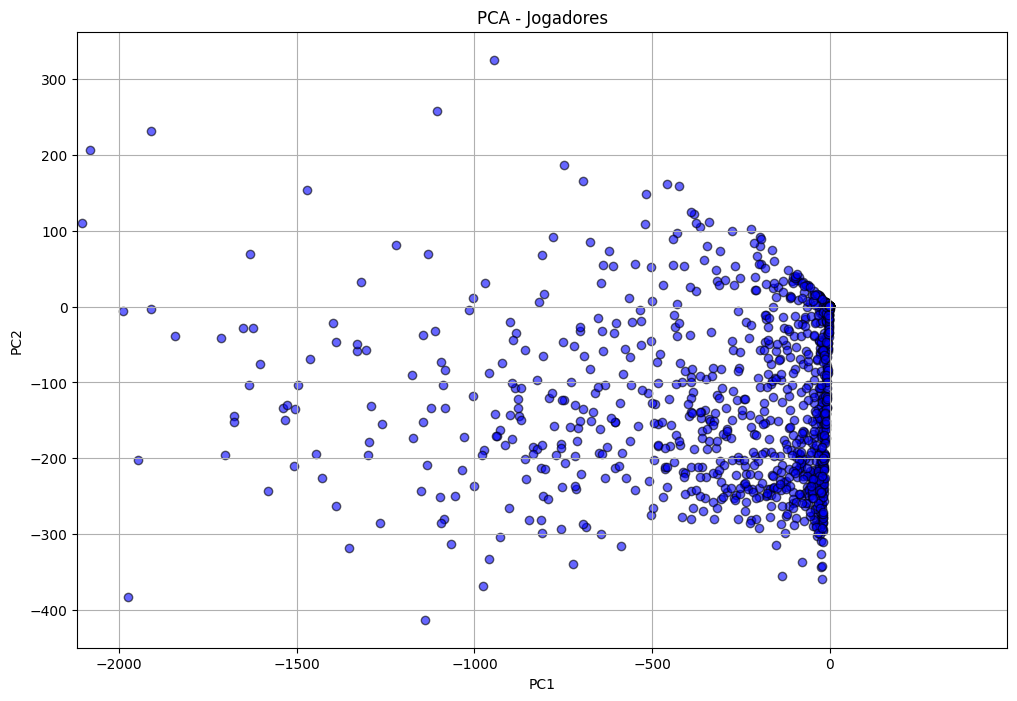

In [52]:
plt.figure(figsize=(12, 8))
plt.scatter(features, pcaFeatures, c='blue', alpha=0.6, edgecolors='k')
plt.xlim(min(features) + 3000, max(features) + 500)

plt.title("PCA - Jogadores")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [53]:
kmeans = KMeans(k=3, featuresCol="pcafeatures", predictionCol="cluster")
model = kmeans.fit(result)
dfClusterizado = model.transform(result)

In [54]:
pipeline = Pipeline(stages=[vector_assembler, pca, kmeans])
model = pipeline.fit(dfVitorias)
df_result = model.transform(dfVitorias)

In [55]:
cluster_data = dfClusterizado.select("name", "pcafeatures", "cluster").rdd.map(
    lambda row: (row["name"], row["pcafeatures"][0], row["pcafeatures"][1], row["cluster"])
).collect()

names = [row[0] for row in cluster_data]
pc1 = [row[1] for row in cluster_data]
pc2 = [row[2] for row in cluster_data]
clusters = [row[3] for row in cluster_data]


In [56]:
cluster_data

[('JNaCo#5244172',
  np.float64(-2.2804277445094794),
  np.float64(1.0624498585898297),
  1),
 ('Brxndoon7-LK#4002715',
  np.float64(-914.2057976079975),
  np.float64(-182.8251591922135),
  2),
 ('bdooory_ab#7095171',
  np.float64(-19.61792631543091),
  np.float64(-230.74324535526463),
  1),
 ('ahevepluto#3505304',
  np.float64(-248.03145105646104),
  np.float64(-142.66032097006087),
  1),
 ('MilkyLemonz-_-#5981249',
  np.float64(-1133.2903326707349),
  np.float64(-208.45270953973562),
  2),
 ('RPDUNKduo#8122914',
  np.float64(-42.84171435607187),
  np.float64(-216.46942500072797),
  1),
 ('CzarnyDelfinek#9059572',
  np.float64(-161.12798961866437),
  np.float64(24.381555567723012),
  1),
 ('SanDrasoSa',
  np.float64(-25.810342496587154),
  np.float64(-170.3793488406218),
  1),
 ('DrunkUnc92#7705654',
  np.float64(-254.90447122780674),
  np.float64(-202.41433547184727),
  1),
 ('whoshotghost#1916366',
  np.float64(-178.15080996782442),
  np.float64(-248.81964087453588),
  1),
 ('Nsory_

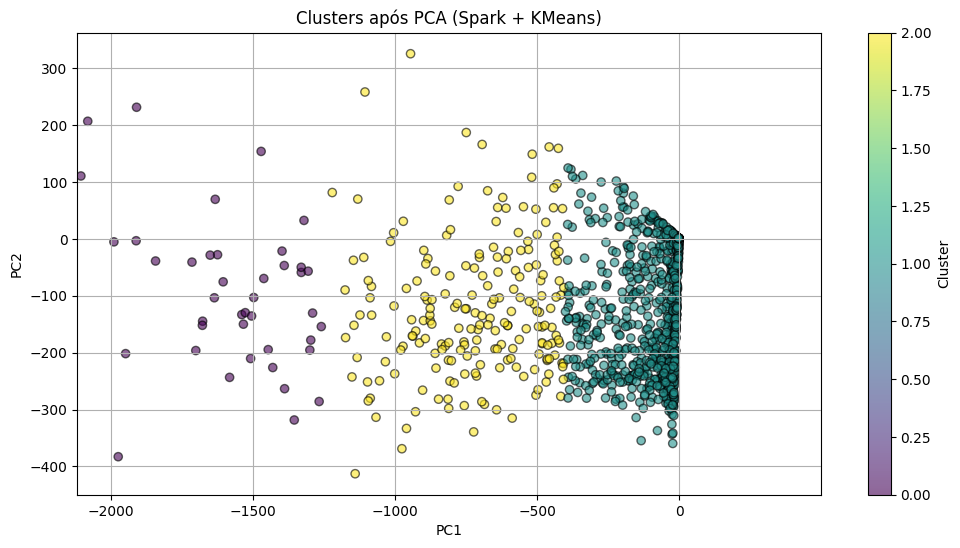

In [57]:
plt.figure(figsize=(12, 6))
scatter = plt.scatter(pc1, pc2, c=clusters, cmap="viridis", alpha=0.6, edgecolors='k')
plt.xlim(min(features) + 3000, max(features) + 500)

plt.title("Clusters após PCA (Spark + KMeans)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


spark.stop()